In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))
from config.paths import DATA_DIR, VECTORSTORE1_DIR, EVAL_PATH,VECTORSTORE_DIR

In [2]:
import json
from pathlib import Path
from typing import List, Dict, Any

# Alternative version: Keep original article numbers from JSON
def load_corpus_with_metadata_original_numbering(json_dir: Path):
    """
    Load corpus chunks preserving the original article numbers from the JSON.
    Labels as [Source Name] Part X | Article Y (original numbering).
    """
    corpus = []
    pairs = []

    FILE_TITLES = {
        "constitution_data_ref.json": "Constitution",
        "labour_ref.json": "Labour Act",
        "Criminal_procedure_code_ref.json": "Criminal Procedure Code",
    }

    for file in json_dir.glob("*.json"):
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

        if isinstance(data, dict) and "document_title" in data:
            file_title = data.get("document_title", "")
        else:
            file_title = FILE_TITLES.get(file.name, file.stem.replace("_", " ").title())

        if not isinstance(data, dict):
            print(f"⚠️ Unexpected format in {file.name}, skipping...")
            continue

        # Process preamble
        preamble = data.get("preamble", "")
        if preamble and preamble.strip():
            corpus.append({
                "text": preamble.strip(),
                "chapter": "Preamble",
                "section": "Preamble",
                "source": file_title,
                "section_type": "preamble"
            })
            pairs.append(f"[{file_title}] Preamble")

        # Process parts and articles (using original article numbers)
        parts = data.get("parts", [])

        for part in parts:
            if not isinstance(part, dict):
                continue

            part_num = part.get("part_number", "")
            part_title = part.get("part_title", "")
            chapter_name = f"Part {part_num}: {part_title}".strip()

            articles = part.get("articles", [])
            for article in articles:
                if not isinstance(article, dict):
                    continue

                art_num = article.get("article_number", "")  # ✅ Use original number
                art_title = article.get("article_title", "")
                clauses = article.get("clauses", [])

                combined_text = "\n\n".join([clause.strip() for clause in clauses if clause and clause.strip()])

                if combined_text:
                    section_name = f"Article {art_num}"  # ✅ Original numbering
                    corpus.append({
                        "text": combined_text,
                        "chapter": chapter_name,
                        "section": section_name,
                        "source": file_title,
                        "section_type": "article",
                        "part_number": part_num,
                        "article_number": art_num,
                        "article_title": art_title,
                        "num_clauses": len([c for c in clauses if c and c.strip()])
                    })
                    pairs.append(f"[{file_title}] {chapter_name} | {section_name}")

        # Process schedules
        schedules = data.get("schedules", [])

        for schedule in schedules:
            if not isinstance(schedule, dict):
                continue

            schedule_num = schedule.get("schedule_number", "")
            schedule_title = schedule.get("schedule_title", "")

            if schedule_title and schedule_title.strip():
                section_name = f"Schedule {schedule_num}"  # ✅ Use original number
                corpus.append({
                    "text": schedule_title.strip(),
                    "chapter": "Schedules",
                    "section": section_name,
                    "source": file_title,
                    "section_type": "schedule",
                    "schedule_number": schedule_num
                })
                pairs.append(f"[{file_title}] Schedules | {section_name}")

    print("\n".join(pairs))
    print(f"\n✅ Loaded {len(corpus)} text chunks (preserving original numbering).")
    return corpus


# Example usage
if __name__ == "__main__":
    from pathlib import Path
    import sys
    
    # Import project paths
    PROJECT_ROOT = Path().resolve().parent
    sys.path.append(str(PROJECT_ROOT))
    from config.paths import DATA_DIR
    
    # Set JSON directory path
    json_dir = DATA_DIR / "processed"
    print("\n" + "=" * 80)
    print("Version 2: Original numbering from JSON (Article 45, 46...)")
    print("=" * 80)
    corpus2 = load_corpus_with_metadata_original_numbering(json_dir)


Version 2: Original numbering from JSON (Article 45, 46...)
[Bank and Financial Institution Act, 2073 (2017)] Preamble
[Bank and Financial Institution Act, 2073 (2017)] Part 1: Preliminary | Article 1
[Bank and Financial Institution Act, 2073 (2017)] Part 1: Preliminary | Article 2
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 3
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 4
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 5
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 6
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 7
[Bank and Financial Institution Act, 2073 (2017)] Part 3: Pro

In [3]:
import numpy as np
from typing import List, Dict
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi


class TFIDFRetriever:
    def __init__(self, docs_with_meta: List[Dict]):
        # Store both text and metadata
        self.docs = docs_with_meta
        texts = [d["text"] for d in docs_with_meta]
        self.vectorizer = TfidfVectorizer(stop_words="english")
        self.doc_vectors = self.vectorizer.fit_transform(texts)

    def retrieve(self, query: str, top_k: int = 5) -> List[Dict]:
        q_vec = self.vectorizer.transform([query])
        scores = np.dot(q_vec, self.doc_vectors.T).toarray()[0]
        top_idx = np.argsort(scores)[::-1][:top_k]
        return [self.docs[i] for i in top_idx]


class BM25Retriever:
    def __init__(self, docs_with_meta: List[Dict]):
        self.docs = docs_with_meta
        self.tokenized = [d["text"].lower().split() for d in docs_with_meta]
        self.bm25 = BM25Okapi(self.tokenized)

    def retrieve(self, query: str, top_k: int = 5) -> List[Dict]:
        tokens = query.lower().split()
        scores = self.bm25.get_scores(tokens)
        top_idx = np.argsort(scores)[::-1][:top_k]
        return [self.docs[i] for i in top_idx]

In [4]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from pathlib import Path
from typing import List, Dict


def load_chroma_retriever(model_name: str, subdir: str, k: int = 5):
    """Load Chroma retriever for a given model store with chapter name only."""
    embedder = HuggingFaceEmbeddings(model_name=model_name)
    db_path = VECTORSTORE1_DIR / subdir
    if not db_path.exists():
        raise FileNotFoundError(f"❌ Vectorstore not found at {db_path}")
    
    db = Chroma(persist_directory=str(db_path), embedding_function=embedder)
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})

    def get_chapter_name(meta: Dict) -> str:
        """Extract chapter name (title only, no numbers) from metadata."""
        # Try to get the full chapter string first
        chapter = meta.get("chapter", "")
        
        # If chapter exists and has a colon, extract the part after it
        if chapter and isinstance(chapter, str) and ":" in chapter:
            # e.g., "Part 2: Fundamental Rights" -> "Fundamental Rights"
            return chapter.split(":", 1)[1].strip()
        elif chapter and isinstance(chapter, str):
            # If no colon, check if it starts with "Part" or "Chapter"
            if chapter.lower().startswith(("part ", "chapter ")):
                # Try to extract just the title if format is "Part X Title"
                parts = chapter.split(maxsplit=2)
                if len(parts) > 2:
                    return parts[2]
            return chapter
        
        # Fallback: get part_title directly
        part_title = meta.get("part_title", "")
        if part_title:
            return part_title
        
        # Last resort fallback
        return "Unknown Chapter"

    class ChromaRetrieverWithMeta:
        """Wrapper retriever returning text and chapter name only."""
        def __init__(self, retriever):
            self.retriever = retriever

        def retrieve(self, query: str, top_k: int = 5) -> List[Dict]:
            docs = self.retriever.invoke(query)
            results = []
            for doc in docs:
                chapter_name = get_chapter_name(doc.metadata)
                source = (
                    doc.metadata.get("source")
                    or doc.metadata.get("file_name")
                    or doc.metadata.get("document_id")
                    or "Unknown Source"
                )
                results.append({
                    "text": doc.page_content,
                    "metadata": chapter_name,
                    "source": source
                })
            return results

    return ChromaRetrieverWithMeta(retriever), db

In [5]:
from typing import List, Dict
import numpy as np
from langchain_core.documents import Document

class CascadedHybridRetriever:
    """
    Hybrid retriever where a semantic retriever gets top_n_sem documents,
    then a keyword-based retriever (e.g., BM25) reranks those for top_k final results.
    Returns only chapter name in metadata.
    """
    def __init__(self, keyword_retriever, semantic_retriever):
        self.keyword_retriever = keyword_retriever
        self.semantic_retriever = semantic_retriever

    def retrieve(self, query: str, top_k: int = 5, top_n_sem: int = 15) -> List[Dict]:
        # --- Step 1: Use semantic retriever first ---
        if hasattr(self.semantic_retriever, "retrieve"):
            sem_docs = self.semantic_retriever.retrieve(query, top_k=top_n_sem)
        elif hasattr(self.semantic_retriever, "invoke"):
            sem_docs = self.semantic_retriever.invoke(query)
        elif hasattr(self.semantic_retriever, "get_relevant_documents"):
            sem_docs = self.semantic_retriever.get_relevant_documents(query)
        else:
            raise AttributeError(
                "Semantic retriever must have invoke(), get_relevant_documents(), or retrieve()."
            )

        # --- Step 2: Normalize semantic outputs ---
        mini_corpus = []
        for d in sem_docs:
            if isinstance(d, dict):
                text = d.get("text", "")
                meta = d.get("metadata", {})
            else:  # LangChain Document
                text = getattr(d, "page_content", "")
                meta = getattr(d, "metadata", {})
            mini_corpus.append({"text": text, "metadata": meta})

        # --- Step 3: Rerank using keyword retriever (BM25) ---
        keyword_refiner = self.keyword_retriever.__class__(mini_corpus)
        refined_docs = keyword_refiner.retrieve(query, top_k=top_k)

        # --- Step 4: Format results with chapter name only ---
        results = []
        for d in refined_docs:
            meta = d.get("metadata", {})
            
            # Get chapter name (title only, no numbers)
            if isinstance(meta, str):
                # If it's already a string, try to extract title
                if ":" in meta:
                    chapter_name = meta.split(":", 1)[1].strip()
                else:
                    chapter_name = meta
            elif isinstance(meta, dict):
                chapter = meta.get("chapter", "")
                
                # Extract title from "Part X: Title" format
                if chapter and ":" in chapter:
                    chapter_name = chapter.split(":", 1)[1].strip()
                elif chapter:
                    chapter_name = chapter
                else:
                    # Fallback to part_title directly
                    chapter_name = meta.get("part_title", "Unknown Chapter")
            else:
                chapter_name = "Unknown Chapter"
            
            # Get source
            if isinstance(meta, dict):
                source = (
                    meta.get("source") 
                    or meta.get("document_title") 
                    or "Unknown Source"
                )
            else:
                source = "Unknown Source"

            results.append({
                "text": d["text"],
                "metadata": chapter_name,
                "source": source
            })

        return results


In [6]:
model_stores = {
        "BAAI/bge-base-en-v1.5": "bge_base_store",
        "BAAI/bge-large-en-v1.5": "bge_large_store",
        "sentence-transformers/all-MiniLM-L6-v2": "minilm_store",
    }


In [7]:
# query = "What constitutes 'mens rea' under the Penal Code, and how is it established in different types of crimes?"
# semantic_retriever, db = load_chroma_retriever("BAAI/bge-large-en-v1.5", "bge_large_store")
# results = semantic_retriever.retrieve(query, top_k=5)

# for r in results:
#     print(r["metadata"])

In [8]:
json_dir = DATA_DIR / "processed"
corpus_with_meta = load_corpus_with_metadata_original_numbering(json_dir)  # returns list of dicts with 'text', 'chapter', 'section'

# Optionally add a 'source' field for each doc
all_docs = []
for doc in corpus_with_meta:
    all_docs.append({
        "text": doc["text"],
        "chapter": doc["chapter"],
        "section": doc["section"],
        "source": doc.get("source")  
    })

[Bank and Financial Institution Act, 2073 (2017)] Preamble
[Bank and Financial Institution Act, 2073 (2017)] Part 1: Preliminary | Article 1
[Bank and Financial Institution Act, 2073 (2017)] Part 1: Preliminary | Article 2
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 3
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 4
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 5
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 6
[Bank and Financial Institution Act, 2073 (2017)] Part 2: Provisions on Incorporation of Bank or Financial Institution | Article 7
[Bank and Financial Institution Act, 2073 (2017)] Part 3: Provisions Concerning Transactions of Securities | Article 8
[Ba

In [9]:
tfidf_model = TFIDFRetriever(all_docs)
bm25_model = BM25Retriever(all_docs)
def inspect_all_models(query: str, top_k: int = 5):
    print("\n" + "="*120)
    print(f" Retrieval Inspection for Query:\n {query}")
    print("="*120)
    
    # --- Keyword / TF-IDF / BM25 ---
    print("\n[TF-IDF]\n")
    result_tfidf = tfidf_model.retrieve(query, top_k=top_k)
    for r in result_tfidf:
        chapter = r.get('chapter', 'Unknown Chapter')
        # Extract title only (after colon if present)
        if ':' in chapter:
            chapter_name = chapter.split(':', 1)[1].strip()
        else:
            chapter_name = chapter
        print(f"{chapter_name}")
    
    print("\n[BM25]\n")
    result_bm25 = bm25_model.retrieve(query, top_k=top_k)
    for r in result_bm25:
        chapter = r.get('chapter', 'Unknown Chapter')
        # Extract title only (after colon if present)
        if ':' in chapter:
            chapter_name = chapter.split(':', 1)[1].strip()
        else:
            chapter_name = chapter
        print(f"{chapter_name}")
    
    # ------- Hybrid --------
    print("\n[Hybrid_Retriever]\n")
    bert, db_hybrid = load_chroma_retriever("BAAI/bge-large-en-v1.5", "bge_large_store")
    hybrid = CascadedHybridRetriever(bm25_model, bert)
    results_hybrid = hybrid.retrieve(query, top_k=5, top_n_sem=20)
    for i, r in enumerate(results_hybrid, 1):
        print(f"{r['metadata']}")
        
    # --- Semantic Vector Models ---
    for model_name, subdir in model_stores.items():
        print(f"\n[{model_name}]\n")
        semantic_retriever, db = load_chroma_retriever(model_name, subdir)
        results = semantic_retriever.retrieve(query, top_k=top_k)
        for r in results:
            print(r["metadata"])
        
    print("\n" + "="*120)

In [10]:
# query ="Can a law passed by Parliament override a constitutional provision? Explain with reference to judicial precedents."
# inspect_all_models(query, 5)
# def extract_chapter1(meta_str: str) -> str:
#     if not meta_str or not isinstance(meta_str, str):
#         return "unknown"
#     parts = meta_str.split("|")
#     chapter = parts[0].strip().lower()
#     if not chapter.startswith("chapter"):
#         chapter = f"{chapter}"
#     return chapter


In [11]:
# ============================================================
# 🔹 Gemini Chroma Retriever (Title-Only Version)
# ============================================================

import os
from pathlib import Path
from dotenv import load_dotenv
import chromadb
from chromadb.config import Settings
from google import genai


class GeminiChromaRetriever:
    def __init__(self, collection_name="legal_docs", db_path=None):
        self.collection_name = collection_name
        self.db_path = db_path or (Path.cwd() / "chroma_db")

        load_dotenv()
        API_KEY = os.getenv("GEMINI_API_KEY")
        if not API_KEY:
            raise ValueError("❌ Missing GEMINI_API_KEY in .env")

        self.client = genai.Client(api_key=API_KEY)
        self.client_chroma = chromadb.PersistentClient(path=str(self.db_path))

        try:
            self.collection = self.client_chroma.get_collection(name=self.collection_name)
        except Exception:
            raise ValueError(f"❌ Collection '{self.collection_name}' not found at {self.db_path}")

    def get_query_embedding(self, text):
        """Generate embedding for the query."""
        response = self.client.models.embed_content(
            model="models/text-embedding-004",
            contents=[text]
        )
        return response.embeddings[0].values

    def retrieve(self, query, top_k=5):
        """
        Retrieve top-k documents but only return metadata title.
        Returns list of dicts like:
        [{"metadata": "Chapter 2|Section 3"}, ...]
        """
        query_emb = self.get_query_embedding(query)
        results = self.collection.query(query_embeddings=[query_emb], n_results=top_k)

        retrieved = []
        for doc, meta, score in zip(
            results["documents"][0],
            results["metadatas"][0],
            results["distances"][0]
        ):
            # ✅ Extract the part_title if present, else fallback to chapter|section
            if isinstance(meta, dict):
                meta_str = meta.get("part_title") or f"{meta.get('chapter', '')}|{meta.get('section', '')}"
            else:
                meta_str = str(meta)

            retrieved.append({
                "metadata": meta_str.strip()
            })

        return retrieved


In [12]:
import json
import numpy as np
from typing import List, Dict
from pathlib import Path
import re

# ============================================================
# 🔹 Metric Functions
# ============================================================
import numpy as np
from typing import List

def precision_at_k(retrieved: List[str], relevant: List[str]) -> float:
    if not retrieved:
        return 0.0
    relevant_hits = sum(1 for r in retrieved if r in relevant)
    return relevant_hits / len(retrieved)


def recall_at_k(retrieved: List[str], relevant: List[str]) -> float:
    if not relevant:
        return 0.0
    relevant_hits = sum(1 for r in retrieved if r in relevant)
    recall = relevant_hits / len(relevant)
    return min(recall, 1.0)  # ✅ Cap recall to 1.0


def hit_rate(retrieved: List[str], relevant: List[str]) -> float:
    return 1.0 if any(r in relevant for r in retrieved) else 0.0


def mrr_at_k(retrieved: List[str], relevant: List[str]) -> float:
    for i, r in enumerate(retrieved, start=1):
        if r in relevant:
            return 1.0 / i
    return 0.0

def ndcg_at_k(retrieved: List[str], relevant: List[str]) -> float:
    if not relevant:
        return 0.0

    # Keep track of which relevant items have been counted
    counted = set()
    dcg = 0.0

    for i, r in enumerate(retrieved[:len(retrieved)]):
        if r in relevant and r not in counted:
            dcg += 1 / np.log2(i + 2)  # rank i+1
            counted.add(r)
            if len(counted) == len(relevant):
                break  # all relevant counted

    # Ideal DCG: all relevant first
    ideal_dcg = sum(1 / np.log2(i + 2) for i in range(len(relevant)))

    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0



# ============================================================
# 🔹 Helper: Extract Chapter (Lowercased)
# ============================================================
def extract_chapter1(meta_str: str) -> str:
    if not meta_str or not isinstance(meta_str, str):
        return "unknown"

    parts = meta_str.split("|")
    chapter = parts[0].strip().lower()

    
    chapter = re.sub(r"^(?:part\s*[-\w]*\s*:?\s*)+", "", chapter, flags=re.IGNORECASE)
    chapter = re.sub(r"^(?:chapter\s*[-\w]*\s*:?\s*)+", "", chapter, flags=re.IGNORECASE)

  
    chapter = re.sub(r"^[-]?\d+\s*:\s*", "", chapter)

  
    chapter = re.sub(r"^\s*:\s*", "", chapter).strip()

    return chapter if chapter else "unknown"


# ============================================================
# 🔹 Benchmarking Function
# ============================================================
def evaluate_retriever1(eval_path: Path, retriever, all_docs: List[Dict], top_k: int = 5):
    """
    Evaluate retriever using queries and relevant chapters from eval dataset.
    Supports both nested and top-level chapter metadata.
    """
    with open(eval_path, "r", encoding="utf-8") as f:
        eval_data = json.load(f)

    metrics = {"precision": [], "recall": [], "hit_rate": [], "mrr": [], "ndcg": []}

    for i, item in enumerate(eval_data, 1):
        query = item.get("query", "")

        # 🟢 Ensure relevant_meta is list
        relevant_meta = item.get("relevant_meta", [])
        if isinstance(relevant_meta, str):
            relevant_meta = [relevant_meta]
        relevant_chapters = [extract_chapter1(m) for m in relevant_meta]

        # --- Retrieve results ---
        top_docs = retriever.retrieve(query, top_k=top_k)
        retrieved_chapters = []

        for d in top_docs:
            # Handle both metadata structures
            if "metadata" in d and isinstance(d["metadata"], dict):
                meta_str = f"{d['metadata'].get('chapter', '')}|{d['metadata'].get('section', '')}"
                retrieved_chapters.append(extract_chapter1(meta_str))
            elif "chapter" in d:
                retrieved_chapters.append(extract_chapter1(d["chapter"]))
            else:
                retrieved_chapters.append("unknown")

        # --- Compute metrics ---
        p = precision_at_k(retrieved_chapters, relevant_chapters)
        r = recall_at_k(retrieved_chapters, relevant_chapters)
        h = hit_rate(retrieved_chapters, relevant_chapters)
        m = mrr_at_k(retrieved_chapters, relevant_chapters)
        n = ndcg_at_k(retrieved_chapters, relevant_chapters)

        metrics["precision"].append(p)
        metrics["recall"].append(r)
        metrics["hit_rate"].append(h)
        metrics["mrr"].append(m)
        metrics["ndcg"].append(n)

        # --- Print result ---
        print(f"\n{i}. {query}")
        print(f"   Relevant: {relevant_chapters}")
        print(f"   Retrieved: {retrieved_chapters[:top_k]}")
        print(f"   → Precision={p:.2f}, Recall={r:.2f}, Hit={h:.1f}, MRR={m:.2f}, NDCG={n:.2f}")

    # --- Summary ---
    summary = {k: float(np.mean(v)) for k, v in metrics.items()}
    print("\n✅ Evaluation Summary (Average):")
    print(json.dumps(summary, indent=2))
    return summary



In [13]:
import json
import numpy as np
from typing import List, Dict
from pathlib import Path

# ============================================================
# 🔹 Helper: Extract Chapter (Lowercased)
# ============================================================
def extract_chapter(meta_str: str) -> str:
    """
    Extract only the 'chapter x' portion from metadata like 'Chapter 3|Section 5',
    normalized to lowercase for comparison consistency.
    """
    if not meta_str or not isinstance(meta_str, str):
        return "unknown"
    parts = meta_str.split("|")
    chapter = parts[0].strip().lower()
    if not chapter.startswith("chapter"):
        chapter = f"{chapter}"
    return chapter


# ============================================================
# 🔹 Benchmarking Function
# ============================================================
def evaluate_retriever(eval_path: Path, retriever, all_docs: List[Dict], top_k: int = 5):
    """
    Evaluate retriever using queries and relevant chapters from eval dataset.
    Retrieved chapters are simplified to only the chapter name (lowercase).
    """
    with open(eval_path, "r", encoding="utf-8") as f:
        eval_data = json.load(f)

    metrics = {"precision": [], "recall": [], "hit_rate": [], "mrr": [], "ndcg": []}

    for i, item in enumerate(eval_data, 1):
        query = item.get("query", "")

        # 🟢 Ensure relevant_meta is list
        relevant_meta = item.get("relevant_meta", [])
        if isinstance(relevant_meta, str):
            relevant_meta = [relevant_meta]

        relevant_chapters = [extract_chapter(m) for m in relevant_meta]

        # --- Retrieve results ---
        top_docs = retriever.retrieve(query, top_k=top_k)
        retrieved_chapters = []
        for d in top_docs:
            if isinstance(d, dict):
                meta = d.get("metadata", "")
                if isinstance(meta, str):
                    retrieved_chapters.append(extract_chapter(meta))
                elif isinstance(meta, dict):
                    # If metadata is a dict, combine chapter and section keys safely
                    meta_str = f"{meta.get('chapter','')}|{meta.get('section','')}"
                    retrieved_chapters.append(extract_chapter(meta_str))
                else:
                    retrieved_chapters.append("unknown")
            else:
                retrieved_chapters.append("unknown")

        # --- Compute metrics ---
        p = precision_at_k(retrieved_chapters, relevant_chapters)
        r = recall_at_k(retrieved_chapters, relevant_chapters)
        h = hit_rate(retrieved_chapters, relevant_chapters)
        m = mrr_at_k(retrieved_chapters, relevant_chapters)
        n = ndcg_at_k(retrieved_chapters, relevant_chapters)

        metrics["precision"].append(p)
        metrics["recall"].append(r)
        metrics["hit_rate"].append(h)
        metrics["mrr"].append(m)
        metrics["ndcg"].append(n)

        # --- Print result ---
        print(f"\n{i}. {query}")
        print(f"   Relevant: {relevant_chapters}")
        print(f"   Retrieved: {retrieved_chapters[:top_k]}")
        print(f"   → Precision={p:.2f}, Recall={r:.2f}, Hit={h:.1f}, MRR={m:.2f}, NDCG={n:.2f}")

    # --- Summary ---
    summary = {k: float(np.mean(v)) for k, v in metrics.items()}
    print("\n✅ Evaluation Summary (Average):")
    print(json.dumps(summary, indent=2))
    return summary



# Example use:
# evaluate_retriever(EVAL_PATH, retriever, all_docs, top_k=5)

In [14]:
EVAL_FILE = EVAL_PATH
results = {}

results["TF-IDF"] = evaluate_retriever1(EVAL_FILE, tfidf_model, all_docs, top_k=5)
print("\n===================================================================\n")
results["BM25"] = evaluate_retriever1(EVAL_FILE, bm25_model, all_docs, top_k=5)
print("\n===================================================================\n")

bert, db_hybrid = load_chroma_retriever("BAAI/bge-large-en-v1.5", "bge_large_store")
hybrid = CascadedHybridRetriever(bm25_model, bert)
results["BGE Large + BM25 (Hybrid)"] = evaluate_retriever(EVAL_FILE, hybrid, all_docs, top_k=5)
print("\n===================================================================\n")

for model_name, subdir in model_stores.items():
    semantic_retriever, db = load_chroma_retriever(model_name, subdir)
    results[model_name] = evaluate_retriever(EVAL_FILE, semantic_retriever, all_docs, top_k=5)
    print("\n===================================================================\n")


gemini_retriever = GeminiChromaRetriever(
    collection_name="legal_docs",
    db_path=VECTORSTORE_DIR
)

results["text-embedding-004"] = evaluate_retriever(
    EVAL_FILE,
    gemini_retriever,
    all_docs,
    top_k=5
)
print("\n===================================================================\n")



1. What are the grounds for disqualification of members of Parliament under the Constitution?
   Relevant: ['federal legislature', 'judiciary']
   Retrieved: ['transitional provisions', 'general provisions', 'transitional provisions', 'federal legislature', 'other commissions']
   → Precision=0.20, Recall=0.50, Hit=1.0, MRR=0.25, NDCG=0.26

2. Explain the constitutional provisions regarding the right to equality and non-discrimination. What are the permitted classifications?
   Relevant: ['fundamental rights and duties', 'preliminary']
   Retrieved: ['fundamental rights and duties', 'general provisions', 'laws relating to property', 'miscellaneous', 'provisions relating to occupation safety and health']
   → Precision=0.20, Recall=0.50, Hit=1.0, MRR=1.00, NDCG=0.61

3. Describe the procedure for declaring a state of emergency under the Constitution of Nepal.
   Relevant: ['emergency power', 'provisions relating to national security']
   Retrieved: ['state legislature', 'state executiv

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5392\2901026034.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name=model_name)
d:\Fusemachine\MyPocketLawyer-AI-Powered-Legal-Aid-Assistant-1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5392\2901026034.py:14: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of t


1. What are the grounds for disqualification of members of Parliament under the Constitution?
   Relevant: ['federal legislature', 'judiciary']
   Retrieved: ['federal legislature', 'federal executive', 'federal legislature', 'financial provisions', 'federal legislature']
   → Precision=0.60, Recall=1.00, Hit=1.0, MRR=1.00, NDCG=0.61

2. Explain the constitutional provisions regarding the right to equality and non-discrimination. What are the permitted classifications?
   Relevant: ['fundamental rights and duties', 'preliminary']
   Retrieved: ['fundamental rights and duties', 'fundamental rights and duties', 'basic provisions relating to labours', 'preliminary', 'preliminary']
   → Precision=0.80, Recall=1.00, Hit=1.0, MRR=1.00, NDCG=0.88

3. Describe the procedure for declaring a state of emergency under the Constitution of Nepal.
   Relevant: ['emergency power', 'provisions relating to national security']
   Retrieved: ['emergency power', 'transitional provisions', 'state executive


📈 Evaluation Summary Table:
                                        precision  recall  hit_rate    mrr  \
TF-IDF                                      0.289   0.590     0.675  0.447   
BM25                                        0.246   0.518     0.639  0.429   
BGE Large + BM25 (Hybrid)                   0.499   0.841     0.904  0.666   
BAAI/bge-base-en-v1.5                       0.494   0.817     0.880  0.770   
BAAI/bge-large-en-v1.5                      0.499   0.841     0.904  0.769   
sentence-transformers/all-MiniLM-L6-v2      0.496   0.831     0.916  0.750   
text-embedding-004                          0.636   0.888     0.916  0.811   

                                         ndcg  
TF-IDF                                  0.411  
BM25                                    0.390  
BGE Large + BM25 (Hybrid)               0.634  
BAAI/bge-base-en-v1.5                   0.702  
BAAI/bge-large-en-v1.5                  0.696  
sentence-transformers/all-MiniLM-L6-v2  0.687  
text-embed

<Figure size 1000x600 with 0 Axes>

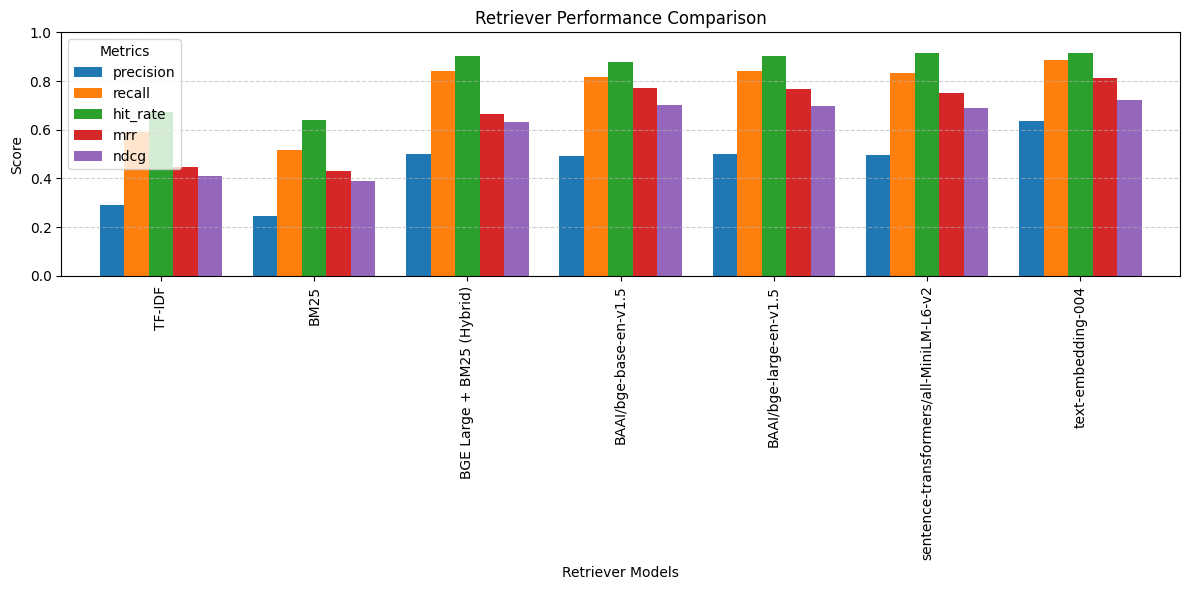

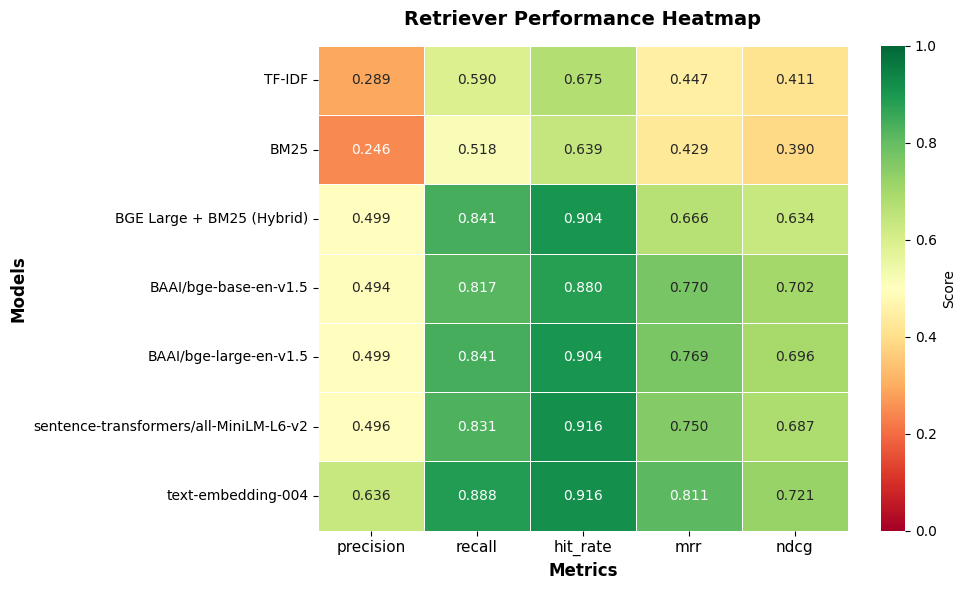

In [16]:
# ============================================================
# 🔹 Create DataFrame for Visualization
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reset matplotlib style to default (removes seaborn styling)
plt.style.use('default')

df = pd.DataFrame(results).T  # transpose to make models as rows
df = df[["precision", "recall", "hit_rate", "mrr", "ndcg"]]  # ensure column order

print("\n📈 Evaluation Summary Table:")
print(df.round(3))

# ============================================================
# 🔹 Plot Bar Chart Comparison
# ============================================================

plt.figure(figsize=(10, 6))
df.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title("Retriever Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Retriever Models")
plt.ylim(0, 1)
plt.legend(title="Metrics")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ============================================================
# 🔹 Plot Heatmap for Quick Comparison
# ============================================================

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, fmt='.3f', cmap='RdYlGn', linewidths=0.5, 
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1)

plt.title('Retriever Performance Heatmap', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Models', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Reset style back to default after heatmap
plt.style.use('default')